# Which country will first-time airbnb users choose?

***
### Brief
New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

Airbnb wants to predict in which destination country a new user from the USA will make his or her first booking:
1. United States of America
2. France
3. Canada
4. Great Britain
5. Estonia
6. Italy
7. Portugal
8. Netherlands
9. Germany
10. Australia  
11. No Destination Found (NDF) 
12. Other

***
### The Data
The data has been provided by airbnb and downloaded from Kaggle. And the [data](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data) contains a rich set of demographics, web session records, and some summary statistics data on about 275,562 (train + test) users from the USA. For context, I've also explored the [international](http://travel.trade.gov/view/m-2015-O-001/index.html) and [domestic](http://www.statista.com/statistics/207103/forecasted-number-of-domestic-trips-in-the-us/) travel data for US Citizens for 2015.

***
### Evaluation Metric

The evaluation metric for this competition is [NDCG (Normalized discounted cumulative gain)](https://www.kaggle.com/wiki/NormalizedDiscountedCumulativeGain) @k where k=5. NDCG is calculated as:

$$DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}},$$

$IDCG_k$ is the maximum possible (ideal) $DCG$ for a given set of queries, documents, and relevances. All NDCG calculations are relative values on the interval 0.0 to 1.0.

$$nDCG_k=\frac{DCG_k}{IDCG_k},$$

For each new user, you are to make a maximum of 5 predictions on the country of the first booking. The ground truth country is marked with relevance = 1, while the rest have relevance = 0.

For example, if for a particular user the destination is FR, then the predictions become:

[ FR ]  gives a $NDCG=\frac{2^{1}-1}{log_{2}(1+1)}=1.0$

[ US, FR ] gives a $DCG=\frac{2^{0}-1}{log_{2}(1+1)}+\frac{2^{1}-1}{log_{2}(2+1)}=\frac{1}{1.58496}=0.6309$

***
### Limitations
1. before early 2013 users could make bookings without creating an account
2. where date_fisrt_booking is populated with nana the destination country is also given as NDF
3. missing data or data munging that need to be done?
4. outliers?
5. unbalanced dataset, skewed to NDF
3. What are the similarities/differences in the destination countries?
4. Demographic differences that could point to preferences?
5. Investigate the impact that user interaction with the website has on destination selection.

***
# Data Exploration

Going in, *my hunch* is that the majority of first time US airbnb users will choose destinations within the USA and then tend to favour Canada and European countries to Australia. 

This is based on data for [international travel](http://travel.trade.gov/view/m-2015-O-001/index.html) by U.S. citizens for the first 10 months of 2015, where all of Europe saw 11,067,879 U.S. citizens (18% of 61,322,698), just above the Canadian figure (11,008,848 citizens; 18%), but still half of number going to Mexico (22,641,533; 36.9% of total). Oceania (used as proxy for Australia in this example) saw 0.8% (511,563) of U.S. citizens visit their shores. In terms of [domestic travel](http://www.statista.com/statistics/207103/forecasted-number-of-domestic-trips-in-the-us/), U.S. citizens took 458.3 million business trips and 1,692.8 million leisure trips in 2015.

What I will be exploring:
* data integrity:
  * the level of missing data 
  * impact of outliers 
  * the amount of data cleaning that will be required before anlaysis can be done


* testing feature characteristics that could point to country preferences:
  * demographic (age, language, gender)
  * how the user come to the website initially (affiliate_channel, affiliate_provider, first_affiliate_tracked)
  * how the user interacts with the website (first_browser,first_device_type)
  * impact of signup process (signup_app, signup_flow, signup_method) on whether the person ends up making a booking or not.
  * after creating an account (date_account_created), what is the delay in searching for places to stay (timestamp_first_active)? And post account creation, how long does it take to finalize the booking (date_first_booking)? And what kind of prediction accuracy do these indicators have?
  

* external influencers about the destination countries themselves that could be attractive to certain users:
 * the distance to the destination (distance_km)
 * how big the country is could potentially point to there being more to explore (destination_km2)
 * foreign, but familiar. Whether english is widely-spoken in the destination country has an impact on it's desirability (destination_language, language_levenshtein_distance)
 

In [2]:
# load libraries that will be used
%matplotlib inline

import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from mpl_toolkits.basemap import Basemap

# make figures better:
font = {'weight':'normal','size':20}
plt.rc('font', **font)
plt.rc('figure', figsize=(9.0, 6.0))
plt.rc('xtick.major', pad=10) # xticks too close to border!
plt.style.use('ggplot')
#print(plt.style.available)

C:\Miniconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# unzip and read data

# Dataset #1: Countries to visit
zf = zipfile.ZipFile('data/countries.csv.zip')
countries = pd.read_csv(zf.open('countries.csv'))

# Dataset #2: Compare demographic distributions within destination countries
zf = zipfile.ZipFile('data/age_gender_bkts.csv.zip')
country_demographics = pd.read_csv(zf.open('age_gender_bkts.csv'))

# Dataset #3: User interactions on airbnb website
zf = zipfile.ZipFile('data/sessions.csv.zip')
user_sessions = pd.read_csv(zf.open('sessions.csv'))

# Dataset #4: Comparing test and training data to what has been provided as user data for 2015
# train
zf = zipfile.ZipFile('data/train_users_2.csv.zip')
train = pd.read_csv(zf.open('train_users_2.csv'))

# test
zf = zipfile.ZipFile('data/test_users.csv.zip')
test = pd.read_csv(zf.open('test_users.csv'))

# concatenate train- and test users together for total sample
users = pd.concat((train, test), axis=0, ignore_index=True)


## Who are these first-time users?

I've combined the train and test data to get a better handle on the over completeness of the sample since an algorthim that performs well on the training data will only do well if the test data is as rich as the training data.

In [20]:
print("Number of users in the training set: %0.0f; \
Number of users in the test set: %0.0f" % (np.shape(train)[0], np.shape(test)[0]))
print("Full Set Rows: %0.0f; -Columns: %0.0f" % np.shape(users))

Number of users in the training set: 213451; Number of users in the test set: 62096
Full Set Rows: 275547; -Columns: 16


The training data represents just over three-quarters of the total sample, but it seems like both data sets have the same poorly populated fields: 

In [30]:
users_nan = users.replace('-unknown-', np.nan)
users_nan_counts = users_nan.isnull().sum().sort_values(ascending=False)
users_nan_summary = (users_nan_counts / users_nan.shape[0]) * 100
users_nan_notzero = users_nan_summary[users_nan_summary > 0]

print('% of rows with missing values for the testing data')
print('--------------------------------------------------')
print(train_nan_notzero)

% of rows with missing values for the testing data
--------------------------------------------------
date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_browser              12.773892
first_affiliate_tracked     2.841402
dtype: float64


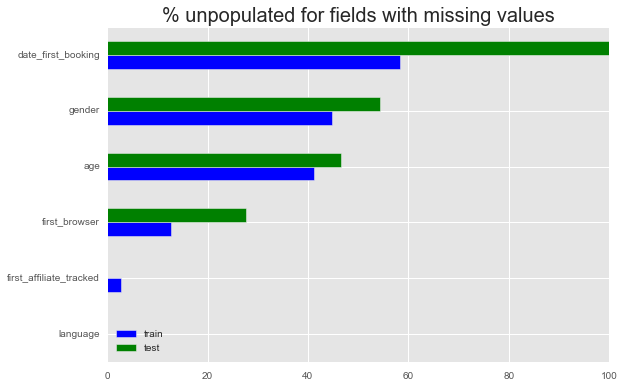

In [71]:
train_nan = train.replace('-unknown-', np.nan)
train_nan_counts = train_nan.isnull().sum().sort_values(ascending=False)
train_nan_summary = (train_nan_counts / train_nan.shape[0]) * 100
train_nan_notzero = train_nan_summary[train_nan_summary > 0]

test_nan = test.replace('-unknown-', np.nan)
test_nan_counts = test_nan.isnull().sum().sort_values(ascending=False)
test_nan_summary = (test_nan_counts / test_nan.shape[0]) * 100
test_nan_notzero = test_nan_summary[test_nan_summary > 0]

nan_comparison = pd.concat([train_nan_notzero,test_nan_notzero], axis=1, names=['train','test'])
nan_comparison.columns = ['train','test']
nan_comparison.sort_values('test', ascending=True).plot(kind='barh')
plt.title('% unpopulated for fields with missing values', fontsize=20);

Taking a closer look at the content of the different fields, it becomes clear that age is not only poorly populated, but there also seems to be a lack of field validation being applied.

In [5]:
for column in users:
    print([column], users[column].unique())

(['affiliate_channel'], array(['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand',
       'remarketing', 'api'], dtype=object))
(['affiliate_provider'], array(['direct', 'google', 'other', 'craigslist', 'facebook', 'vast',
       'bing', 'meetup', 'facebook-open-graph', 'email-marketing', 'yahoo',
       'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex', 'daum'], dtype=object))
(['age'], array([             nan,   3.80000000e+01,   5.60000000e+01,
         4.20000000e+01,   4.10000000e+01,   4.60000000e+01,
         4.70000000e+01,   5.00000000e+01,   3.60000000e+01,
         3.70000000e+01,   3.30000000e+01,   3.10000000e+01,
         2.90000000e+01,   3.00000000e+01,   4.00000000e+01,
         2.60000000e+01,   3.20000000e+01,   3.50000000e+01,
         5.90000000e+01,   4.90000000e+01,   4.40000000e+01,
         3.40000000e+01,   2.80000000e+01,   1.90000000e+01,
         5.30000000e+01,   5.20000000e+01,   3.90000000e+01,
         5.70000000e+01,   2.50000000e+0

In [72]:
print users.age.describe()
print
print sum(users.age>100)
print sum(users.age<18)

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

2690
188


# Preliminary Findings

There are a lot of categorical variable so this chart is a bit crowded. Below are some quick comments about each.
* Starting with gender, it appears users with 'unknown' gender book less frequently than those with a known one while users with gender 'other' book more frequently
* Users with the 'google' signup_method book less frequently than 'basic' or 'facebook'
* Users with signup_flow 3 book more frequently than any other category while several have nearly 100% 'NDF'
* Users with affiliate_channel 'content' book less frequently than other categories
* Users with affiliate_provider 'craigslist', direct', and 'google' book more frequently than other categories (this begs the question as to why the google affiliate channel is more effective than the google sign up method)
* Users with first_affiliate_tracked 'local ops' book less frequently than other categories
* Users with signup_app 'Web' booked the most frequently, while those with 'Android' booked the least
* Users with first_device_type 'Mac_Desktop' booked the most frequently, while those with 'Android Phone' booked the least
The chart on first_browser highlights the large number used above all else; it is difficult to glean any meaningful insights beyond that some obscure browsers that are not likely widely used have very high or very low booking frequencies.
The chart on language is somewhat surprising given that all the users we

# Test my Hyphotheses
Any preliminary exploration you’ve performed and your initial findings. Test the hypotheses one at a time. Often, the data story emerges as a result of a sequence of testing hypothesis e.g. You first tested if X was true, and because it wasn't, you tried Y, which turned out to be true.

# Course of Action
Based on these findings, what approach are you going to take? How has your approach changed from what you initially proposed, if applicable?

# Source Additional Data
Are there other datasets you can find, use and combine with, to answer the questions that matter?

### Dataset #3: User Sessions 

In [6]:
print("Rows: %0.0f; Columns: %0.0f" % np.shape(user_sessions))
user_sessions.tail()

Rows: 10567737; Columns: 6


,user_id,action,action_type,action_detail,device_type,secs_elapsed
10567732,9uqfg8txu3,dashboard,view,dashboard,Windows Desktop,556
10567733,9uqfg8txu3,edit,view,edit_profile,Windows Desktop,6624
10567734,9uqfg8txu3,webcam_upload,-unknown-,-unknown-,Windows Desktop,200125
10567735,9uqfg8txu3,active,-unknown-,-unknown-,-unknown-,17624
10567736,9uqfg8txu3,show_personalize,data,user_profile_content_update,Windows Desktop,1221


In [7]:
top_tail = user_sessions[user_sessions.user_id.isin(['d1mm9tcy42','9uqfg8txu3'])].sort_values('action')
top_tail.groupby(['user_id','action','action_type','action_detail']).count()

device_type  \
user_id    action                      action_type      action_detail                              
9uqfg8txu3 active                      -unknown-        -unknown-                              2   
           callback                    partner_callback oauth_response                         1   
           create                      submit           create_phone_numbers                   2   
           dashboard                   view             dashboard                              1   
           edit                        view             edit_profile                           4   
           header_userpic              data             header_userpic                         1   
           languages_multiselect       -unknown-        -unknown-                              1   
           show                        view             user_profile                           1   
           show_personalize            data             user_profile_content_update            1   
           update                      submit           update_user_profile                    1   
           webcam_upload               -unknown-        -unknown-                              1   
d1mm9tcy42 active                      -unknown-        -unknown-                              1   
           ajax_refresh_subtotal       click            change_trip_characteristics            8   
           ask_question                submit           contact_host                           1   
           decision_tree               -unknown-        -unknown-                              1   
           faq_experiment_ids          -unknown-        -unknown-                              1   
           header_userpic              data             header_userpic                         1   
           hosting_social_proof        -unknown-        -unknown-                              2   
           index                       view             view_search_results                   11   
           multi                       -unknown-        -unknown-                              1   
           other_hosting_reviews_first -unknown-        -unknown-                              1   
           personalize                 data             wishlist_content_update               25   
           recent_reservations         -unknown-        -unknown-                              1   
           search_results              click            view_search_results                   12   
           show                        view             p3                                    14   
           similar_listings            data             similar_listings                       9   

                                                                                     secs_elapsed  
user_id    action                      action_type      action_detail                              
9uqfg8txu3 active                      -unknown-        -unknown-                               2  
           callback                    partner_callback oauth_response                          0  
           create                      submit           create_phone_numbers                    2  
           dashboard                   view             dashboard                               1  
           edit                        view             edit_profile                            4  
           header_userpic              data             header_userpic                          1  
           languages_multiselect       -unknown-        -unknown-                               1  
           show                        view             user_profile                            1  
           show_personalize            data             user_profile_content_update             1  
           update                      submit           update_user_profile                     1  
           webcam_upload               -unknown-        -unknown-                   

In [8]:
sessions_nan = user_sessions.replace('-unknown-', np.nan)
sessions_nan_counts = sessions_nan.isnull().sum().sort_values(ascending=False)
sessions_nan_summary = (sessions_nan_counts / sessions_nan.shape[0]) * 100

print('Number  of rows with missing values')
print('-------------------------------------')
print(sessions_nan_counts)

print('% of rows with missing values')
print('-------------------------------------')
print(sessions_nan_summary)

Number  of rows with missing values
-------------------------------------
action_type      2157374
action_detail    2157345
device_type       211279
secs_elapsed      136031
action             79626
user_id            34496
dtype: int64
% of rows with missing values
-------------------------------------
action_type      20.414721
action_detail    20.414446
device_type       1.999283
secs_elapsed      1.287229
action            0.753482
user_id           0.326428
dtype: float64


The session data seems to hold a rich variety of metrics, but the aren't really well populated for action type and action detail. And it would seems like unknowns in action type would also mean unknwons in actiona detail. But do I care about these fields?

In [9]:
# What values do action types tend to hold?
sessions_action_types = (user_sessions.action_type.value_counts() / user_sessions.shape[0]) * 100 
sessions_action_types

view                33.695975
data                19.907479
click               18.889408
-unknown-            9.757718
submit               5.898680
message_post         0.824235
partner_callback     0.181042
booking_request      0.177644
modify               0.010778
booking_response     0.000038
Name: action_type, dtype: float64

In [10]:
# top 20 action details
sessions_action_details = (user_sessions.action_detail.value_counts() / user_sessions.shape[0]) * 100 
sessions_action_details.head(20)

view_search_results            16.814243
p3                             13.025968
-unknown-                       9.757444
wishlist_content_update         6.688509
user_profile                    6.215512
change_trip_characteristics     4.615406
similar_listings                3.450351
user_social_connections         3.187049
update_listing                  2.552855
listing_reviews                 2.545682
dashboard                       1.447349
user_wishlists                  1.444699
header_userpic                  1.342104
message_thread                  1.252823
edit_profile                    1.028470
message_post                    0.824235
contact_host                    0.766872
unavailable_dates               0.736156
confirm_email_link              0.552834
create_user                     0.519298
Name: action_detail, dtype: float64

As the name suggests, there is more detail under the Action Detail field about the action performed but very little other than the occurance of reservation as a description pops out as relevant. Action Type looks like it should be the most promising of the 3 action related fields, because of the direct mention of booking request and booking response. So let's take a closer look.

In [11]:
user_sessions[user_sessions.action_type.isin(['booking_request','booking_response'])] \
.groupby(['action_type','action','action_detail']).count()

user_id  device_type  \
action_type      action        action_detail                         
booking_request  at_checkpoint at_checkpoint     5166         5170   
                 pending       pending          13596        13603   
booking_response booking       booking              4            4   

                                              secs_elapsed  
action_type      action        action_detail                
booking_request  at_checkpoint at_checkpoint          5128  
                 pending       pending               13521  
booking_response booking       booking                   4

It seems action and action details both hold the same information for these two booking related action types. When I looked at whether I can used the occurance of checkpoint, pending and booking as field values in the relatively complete action field (0.75% missing records), in the hopes of filling in action type and action detail statuses I came up short unfortunately as 2,391 is only a drop in the bucket compared to the total unknown values of 2,157,374 (please see below).

In [12]:
user_sessions[user_sessions.action.isin(['at_checkpoint','pending','booking'])] \
.groupby(['action_type','action','action_detail']).count()

user_id  device_type  \
action_type      action        action_detail                         
-unknown-        pending       -unknown-         2391         2397   
booking_request  at_checkpoint at_checkpoint     5166         5170   
                 pending       pending          13596        13603   
booking_response booking       booking              4            4   

                                              secs_elapsed  
action_type      action        action_detail                
-unknown-        pending       -unknown-              2397  
booking_request  at_checkpoint at_checkpoint          5128  
                 pending       pending               13521  
booking_response booking       booking                   4

I feature that is populated quite well is the type of device that was used to interact with the airbnb platform, and shows that the majority, 59.43% of users tended to use their desktop. 

In [13]:
user_sessions.groupby('device_type').size().sort_values(ascending=False) / user_sessions.shape[0] *100

device_type
Mac Desktop                         34.011880
Windows Desktop                     25.157127
iPhone                              19.919411
Android Phone                        7.945287
iPad Tablet                          6.466985
Android App Unknown Phone/Tablet     2.589504
-unknown-                            1.999283
Tablet                               1.323708
Linux Desktop                        0.268487
Chromebook                           0.211474
iPodtouch                            0.077576
Windows Phone                        0.019370
Blackberry                           0.009264
Opera Phone                          0.000643
dtype: float64

In [14]:
user_sessions.groupby('device_type')['secs_elapsed'].agg(['min','mean','median','max'])\
.sort_values('median',ascending=False) / 60

,min,mean,median,max
device_type,,,,
Blackberry,0.000000,897.149771,69.658333,28251.233333
Windows Phone,0.000000,700.293252,64.583333,28407.400000
-unknown-,0.000000,426.720023,64.433333,29875.583333
iPad Tablet,0.000000,351.012478,30.133333,29986.500000
Chromebook,0.000000,393.214455,29.633333,29916.816667
Linux Desktop,0.000000,420.764027,27.391667,29579.366667
Windows Desktop,0.000000,367.968227,21.933333,29990.800000
Tablet,0.000000,274.878099,21.750000,29881.400000
Mac Desktop,0.000000,331.945146,19.883333,29999.616667


# Recommendations
A final paper explaining the problem, your approach and your findings in complete technical detail. Include ideas for further research, as well as up to 3 concrete recommendations for your client on how to use your findings.

# Further Research

Include ideas for further research, as well as up to 3 concrete recommendations for your client on how to use your findings.

In [15]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
# you need to run the line above only once
%load_ext version_information
#%reload_ext version_information

%version_information numpy, scipy, matplotlib

Software versions
Python 2.7.11 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.0.2
OS Windows 7 6.1.7601 SP1
numpy 1.10.1
scipy 0.16.0
matplotlib 1.5.1
Tue Feb 02 19:03:16 2016 South Africa Standard Time

# Acknowledgements
I have learnt a lot from the work of my fellow Kagglers, and would like to acknowlegde their influence on my work:
* David Gasquez's https://www.kaggle.com/davidgasquez/airbnb-recruiting-new-user-bookings/user-data-exploration/notebook
* Kevin Wu https://www.kaggle.com/kevinwu06/airbnb-recruiting-new-user-bookings/airbnb-exploratory-analysis/notebook